In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm

# Use GPU if available
"""
Reference: https://pytorch.org/get-started/locally/
"""

# Device Configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using NVIDIA GPU (CUDA)


In [418]:
# Load the dataset
df = pd.read_parquet('../data/processed_emoji_dataset.parquet')

# Convert combined_embedding to float32 numpy array
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

# Custom Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        
        # Transform image to 16x16 RGB
        # if self.transform:
        #     image_tensor = self.transform(image_tensor)
        
        return embedding, image_tensor

# Transform for 16x16 RGB
# transform = transforms.Compose([
#     transforms.Resize((16, 16)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] for RGB
# ])

# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [419]:
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_channels * 16 * 16),
            nn.Tanh()
        )

    def forward(self, noise, embed):
        x = torch.cat((noise, embed), dim=1)
        x = self.model(x)
        return x.view(x.size(0), 3, 16, 16)

In [420]:
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_channels * 16 * 16 + embedding_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, embed):
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, embed), dim=1)
        return self.model(x)

In [421]:
noise_dim = 100  # Dimension of noise vector
embedding_dim = len(df['combined_embedding'][0])  # Length of SBERT embedding

# Initialize Generator and Discriminator
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [422]:
num_epochs = 100

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for combined_embeddings, real_images in progress_bar:
        combined_embeddings = combined_embeddings.to(device)
        real_images = real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = generator(noise, combined_embeddings)
        
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        real_outputs = discriminator(real_images, combined_embeddings)
        fake_outputs = discriminator(fake_images.detach(), combined_embeddings)
        
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, combined_embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Using tqdm.write() for clean logging
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 1/100: 100%|██████████| 196/196 [00:05<00:00, 32.86it/s]


Epoch [1/100] | D Loss: 0.0653 | G Loss: 7.0713


Epoch 2/100: 100%|██████████| 196/196 [00:04<00:00, 47.94it/s]


Epoch [2/100] | D Loss: 0.2299 | G Loss: 3.5326


Epoch 3/100: 100%|██████████| 196/196 [00:04<00:00, 48.85it/s]


Epoch [3/100] | D Loss: 0.5543 | G Loss: 4.4027


Epoch 4/100: 100%|██████████| 196/196 [00:03<00:00, 50.34it/s]


Epoch [4/100] | D Loss: 0.2140 | G Loss: 5.0150


Epoch 5/100: 100%|██████████| 196/196 [00:03<00:00, 50.60it/s]


Epoch [5/100] | D Loss: 0.5832 | G Loss: 2.7481


Epoch 6/100: 100%|██████████| 196/196 [00:04<00:00, 47.58it/s]


Epoch [6/100] | D Loss: 0.5352 | G Loss: 5.5370


Epoch 7/100: 100%|██████████| 196/196 [00:04<00:00, 47.04it/s]


Epoch [7/100] | D Loss: 0.2842 | G Loss: 4.4838


Epoch 8/100: 100%|██████████| 196/196 [00:03<00:00, 50.27it/s]


Epoch [8/100] | D Loss: 0.1574 | G Loss: 3.6240


Epoch 9/100: 100%|██████████| 196/196 [00:03<00:00, 50.09it/s]


Epoch [9/100] | D Loss: 0.5328 | G Loss: 3.5827


Epoch 10/100: 100%|██████████| 196/196 [00:03<00:00, 49.86it/s]


Epoch [10/100] | D Loss: 0.2749 | G Loss: 3.3618


Epoch 11/100: 100%|██████████| 196/196 [00:04<00:00, 46.96it/s]


Epoch [11/100] | D Loss: 0.2972 | G Loss: 2.4299


Epoch 12/100: 100%|██████████| 196/196 [00:04<00:00, 43.52it/s]


Epoch [12/100] | D Loss: 0.3945 | G Loss: 2.5422


Epoch 13/100: 100%|██████████| 196/196 [00:03<00:00, 49.00it/s]


Epoch [13/100] | D Loss: 0.3740 | G Loss: 6.2144


Epoch 14/100: 100%|██████████| 196/196 [00:03<00:00, 50.22it/s]


Epoch [14/100] | D Loss: 0.1573 | G Loss: 3.3541


Epoch 15/100: 100%|██████████| 196/196 [00:03<00:00, 50.60it/s]


Epoch [15/100] | D Loss: 0.3909 | G Loss: 2.4093


Epoch 16/100: 100%|██████████| 196/196 [00:03<00:00, 49.60it/s]


Epoch [16/100] | D Loss: 0.6224 | G Loss: 1.9809


Epoch 17/100: 100%|██████████| 196/196 [00:03<00:00, 50.23it/s]


Epoch [17/100] | D Loss: 0.4715 | G Loss: 2.9288


Epoch 18/100: 100%|██████████| 196/196 [00:03<00:00, 51.03it/s]


Epoch [18/100] | D Loss: 0.4018 | G Loss: 3.9223


Epoch 19/100: 100%|██████████| 196/196 [00:04<00:00, 48.02it/s]


Epoch [19/100] | D Loss: 0.4934 | G Loss: 1.9013


Epoch 20/100: 100%|██████████| 196/196 [00:04<00:00, 48.93it/s]


Epoch [20/100] | D Loss: 0.2529 | G Loss: 3.5891


Epoch 21/100: 100%|██████████| 196/196 [00:03<00:00, 50.89it/s]


Epoch [21/100] | D Loss: 0.2008 | G Loss: 4.4644


Epoch 22/100: 100%|██████████| 196/196 [00:03<00:00, 51.04it/s]


Epoch [22/100] | D Loss: 0.4661 | G Loss: 2.1511


Epoch 23/100: 100%|██████████| 196/196 [00:03<00:00, 51.06it/s]


Epoch [23/100] | D Loss: 0.6002 | G Loss: 2.6727


Epoch 24/100: 100%|██████████| 196/196 [00:04<00:00, 48.74it/s]


Epoch [24/100] | D Loss: 1.0753 | G Loss: 3.3043


Epoch 25/100: 100%|██████████| 196/196 [00:04<00:00, 48.54it/s]


Epoch [25/100] | D Loss: 0.3836 | G Loss: 2.7480


Epoch 26/100: 100%|██████████| 196/196 [00:03<00:00, 49.17it/s]


Epoch [26/100] | D Loss: 0.3735 | G Loss: 2.2826


Epoch 27/100: 100%|██████████| 196/196 [00:03<00:00, 50.06it/s]


Epoch [27/100] | D Loss: 0.6615 | G Loss: 2.9839


Epoch 28/100: 100%|██████████| 196/196 [00:04<00:00, 48.86it/s]


Epoch [28/100] | D Loss: 0.6546 | G Loss: 2.0388


Epoch 29/100: 100%|██████████| 196/196 [00:03<00:00, 49.57it/s]


Epoch [29/100] | D Loss: 0.6640 | G Loss: 1.7048


Epoch 30/100: 100%|██████████| 196/196 [00:03<00:00, 50.69it/s]


Epoch [30/100] | D Loss: 0.4910 | G Loss: 2.4125


Epoch 31/100: 100%|██████████| 196/196 [00:03<00:00, 50.53it/s]


Epoch [31/100] | D Loss: 0.4148 | G Loss: 3.6454


Epoch 32/100: 100%|██████████| 196/196 [00:03<00:00, 50.11it/s]


Epoch [32/100] | D Loss: 0.5563 | G Loss: 2.5833


Epoch 33/100: 100%|██████████| 196/196 [00:03<00:00, 50.06it/s]


Epoch [33/100] | D Loss: 0.9206 | G Loss: 1.7826


Epoch 34/100: 100%|██████████| 196/196 [00:03<00:00, 50.65it/s]


Epoch [34/100] | D Loss: 0.9508 | G Loss: 3.7365


Epoch 35/100: 100%|██████████| 196/196 [00:04<00:00, 47.26it/s]


Epoch [35/100] | D Loss: 0.9352 | G Loss: 1.7660


Epoch 36/100: 100%|██████████| 196/196 [00:03<00:00, 49.94it/s]


Epoch [36/100] | D Loss: 0.5805 | G Loss: 1.8558


Epoch 37/100: 100%|██████████| 196/196 [00:04<00:00, 48.96it/s]


Epoch [37/100] | D Loss: 0.4939 | G Loss: 2.4850


Epoch 38/100: 100%|██████████| 196/196 [00:04<00:00, 44.52it/s]


Epoch [38/100] | D Loss: 0.9573 | G Loss: 2.0481


Epoch 39/100: 100%|██████████| 196/196 [00:04<00:00, 46.45it/s]


Epoch [39/100] | D Loss: 0.5487 | G Loss: 3.5222


Epoch 40/100: 100%|██████████| 196/196 [00:04<00:00, 46.31it/s]


Epoch [40/100] | D Loss: 0.6916 | G Loss: 2.8771


Epoch 41/100: 100%|██████████| 196/196 [00:03<00:00, 49.04it/s]


Epoch [41/100] | D Loss: 0.4243 | G Loss: 2.0176


Epoch 42/100: 100%|██████████| 196/196 [00:03<00:00, 49.36it/s]


Epoch [42/100] | D Loss: 0.5686 | G Loss: 1.9376


Epoch 43/100: 100%|██████████| 196/196 [00:04<00:00, 45.99it/s]


Epoch [43/100] | D Loss: 0.6932 | G Loss: 2.4734


Epoch 44/100: 100%|██████████| 196/196 [00:04<00:00, 46.52it/s]


Epoch [44/100] | D Loss: 0.6433 | G Loss: 2.0687


Epoch 45/100: 100%|██████████| 196/196 [00:04<00:00, 44.85it/s]


Epoch [45/100] | D Loss: 0.6481 | G Loss: 2.2077


Epoch 46/100: 100%|██████████| 196/196 [00:04<00:00, 48.28it/s]


Epoch [46/100] | D Loss: 0.6319 | G Loss: 2.5191


Epoch 47/100: 100%|██████████| 196/196 [00:04<00:00, 46.06it/s]


Epoch [47/100] | D Loss: 0.5034 | G Loss: 1.8911


Epoch 48/100: 100%|██████████| 196/196 [00:04<00:00, 48.95it/s]


Epoch [48/100] | D Loss: 1.2609 | G Loss: 3.0508


Epoch 49/100: 100%|██████████| 196/196 [00:04<00:00, 43.50it/s]


Epoch [49/100] | D Loss: 0.8557 | G Loss: 1.5522


Epoch 50/100: 100%|██████████| 196/196 [00:04<00:00, 44.48it/s]


Epoch [50/100] | D Loss: 0.7317 | G Loss: 2.9981


Epoch 51/100: 100%|██████████| 196/196 [00:04<00:00, 48.08it/s]


Epoch [51/100] | D Loss: 0.7919 | G Loss: 1.9167


Epoch 52/100: 100%|██████████| 196/196 [00:04<00:00, 48.69it/s]


Epoch [52/100] | D Loss: 0.8380 | G Loss: 2.1048


Epoch 53/100: 100%|██████████| 196/196 [00:04<00:00, 48.32it/s]


Epoch [53/100] | D Loss: 1.2180 | G Loss: 1.4676


Epoch 54/100: 100%|██████████| 196/196 [00:04<00:00, 48.13it/s]


Epoch [54/100] | D Loss: 0.7673 | G Loss: 2.6540


Epoch 55/100: 100%|██████████| 196/196 [00:04<00:00, 48.05it/s]


Epoch [55/100] | D Loss: 0.5163 | G Loss: 2.2381


Epoch 56/100: 100%|██████████| 196/196 [00:03<00:00, 49.01it/s]


Epoch [56/100] | D Loss: 0.8027 | G Loss: 2.0281


Epoch 57/100: 100%|██████████| 196/196 [00:04<00:00, 48.96it/s]


Epoch [57/100] | D Loss: 0.8303 | G Loss: 2.6906


Epoch 58/100: 100%|██████████| 196/196 [00:04<00:00, 47.76it/s]


Epoch [58/100] | D Loss: 0.5114 | G Loss: 2.6464


Epoch 59/100: 100%|██████████| 196/196 [00:03<00:00, 49.20it/s]


Epoch [59/100] | D Loss: 0.8126 | G Loss: 2.1024


Epoch 60/100: 100%|██████████| 196/196 [00:04<00:00, 48.57it/s]


Epoch [60/100] | D Loss: 0.8951 | G Loss: 2.1714


Epoch 61/100: 100%|██████████| 196/196 [00:04<00:00, 48.85it/s]


Epoch [61/100] | D Loss: 1.0926 | G Loss: 1.5945


Epoch 62/100: 100%|██████████| 196/196 [00:03<00:00, 49.31it/s]


Epoch [62/100] | D Loss: 0.6170 | G Loss: 1.9785


Epoch 63/100: 100%|██████████| 196/196 [00:04<00:00, 48.76it/s]


Epoch [63/100] | D Loss: 0.7439 | G Loss: 2.1808


Epoch 64/100: 100%|██████████| 196/196 [00:04<00:00, 46.93it/s]


Epoch [64/100] | D Loss: 0.7260 | G Loss: 2.3978


Epoch 65/100: 100%|██████████| 196/196 [00:03<00:00, 49.35it/s]


Epoch [65/100] | D Loss: 0.7387 | G Loss: 2.5074


Epoch 66/100: 100%|██████████| 196/196 [00:03<00:00, 49.87it/s]


Epoch [66/100] | D Loss: 0.9437 | G Loss: 2.0663


Epoch 67/100: 100%|██████████| 196/196 [00:03<00:00, 50.38it/s]


Epoch [67/100] | D Loss: 0.7288 | G Loss: 1.9462


Epoch 68/100: 100%|██████████| 196/196 [00:03<00:00, 49.81it/s]


Epoch [68/100] | D Loss: 0.9764 | G Loss: 1.5597


Epoch 69/100: 100%|██████████| 196/196 [00:04<00:00, 47.92it/s]


Epoch [69/100] | D Loss: 1.1028 | G Loss: 2.1489


Epoch 70/100: 100%|██████████| 196/196 [00:04<00:00, 46.09it/s]


Epoch [70/100] | D Loss: 0.8112 | G Loss: 1.2532


Epoch 71/100: 100%|██████████| 196/196 [00:04<00:00, 46.32it/s]


Epoch [71/100] | D Loss: 0.6840 | G Loss: 3.2381


Epoch 72/100: 100%|██████████| 196/196 [00:04<00:00, 46.32it/s]


Epoch [72/100] | D Loss: 0.7964 | G Loss: 1.4426


Epoch 73/100: 100%|██████████| 196/196 [00:03<00:00, 49.63it/s]


Epoch [73/100] | D Loss: 0.7764 | G Loss: 1.6524


Epoch 74/100: 100%|██████████| 196/196 [00:04<00:00, 40.70it/s]


Epoch [74/100] | D Loss: 0.8855 | G Loss: 2.1619


Epoch 75/100: 100%|██████████| 196/196 [00:04<00:00, 48.06it/s]


Epoch [75/100] | D Loss: 0.6036 | G Loss: 2.8770


Epoch 76/100: 100%|██████████| 196/196 [00:03<00:00, 49.03it/s]


Epoch [76/100] | D Loss: 0.6025 | G Loss: 2.7296


Epoch 77/100: 100%|██████████| 196/196 [00:04<00:00, 48.78it/s]


Epoch [77/100] | D Loss: 0.7182 | G Loss: 2.4915


Epoch 78/100: 100%|██████████| 196/196 [00:03<00:00, 49.59it/s]


Epoch [78/100] | D Loss: 0.7493 | G Loss: 1.5210


Epoch 79/100: 100%|██████████| 196/196 [00:03<00:00, 49.79it/s]


Epoch [79/100] | D Loss: 0.8342 | G Loss: 2.2463


Epoch 80/100: 100%|██████████| 196/196 [00:04<00:00, 48.68it/s]


Epoch [80/100] | D Loss: 0.4191 | G Loss: 1.8542


Epoch 81/100: 100%|██████████| 196/196 [00:03<00:00, 49.60it/s]


Epoch [81/100] | D Loss: 0.8568 | G Loss: 3.9357


Epoch 82/100: 100%|██████████| 196/196 [00:03<00:00, 49.69it/s]


Epoch [82/100] | D Loss: 0.7643 | G Loss: 3.5622


Epoch 83/100: 100%|██████████| 196/196 [00:03<00:00, 49.57it/s]


Epoch [83/100] | D Loss: 0.4844 | G Loss: 3.0754


Epoch 84/100: 100%|██████████| 196/196 [00:04<00:00, 46.60it/s]


Epoch [84/100] | D Loss: 0.6455 | G Loss: 1.5279


Epoch 85/100: 100%|██████████| 196/196 [00:04<00:00, 47.19it/s]


Epoch [85/100] | D Loss: 0.6064 | G Loss: 2.8543


Epoch 86/100: 100%|██████████| 196/196 [00:04<00:00, 48.96it/s]


Epoch [86/100] | D Loss: 0.7291 | G Loss: 3.3608


Epoch 87/100: 100%|██████████| 196/196 [00:03<00:00, 49.88it/s]


Epoch [87/100] | D Loss: 0.8590 | G Loss: 2.9690


Epoch 88/100: 100%|██████████| 196/196 [00:03<00:00, 50.29it/s]


Epoch [88/100] | D Loss: 0.8598 | G Loss: 2.6512


Epoch 89/100: 100%|██████████| 196/196 [00:03<00:00, 50.58it/s]


Epoch [89/100] | D Loss: 0.5783 | G Loss: 3.3591


Epoch 90/100: 100%|██████████| 196/196 [00:03<00:00, 50.41it/s]


Epoch [90/100] | D Loss: 0.6192 | G Loss: 1.9891


Epoch 91/100: 100%|██████████| 196/196 [00:04<00:00, 47.29it/s]


Epoch [91/100] | D Loss: 0.6469 | G Loss: 3.1433


Epoch 92/100: 100%|██████████| 196/196 [00:04<00:00, 48.63it/s]


Epoch [92/100] | D Loss: 1.0519 | G Loss: 4.4314


Epoch 93/100: 100%|██████████| 196/196 [00:03<00:00, 49.05it/s]


Epoch [93/100] | D Loss: 0.5814 | G Loss: 3.0805


Epoch 94/100: 100%|██████████| 196/196 [00:04<00:00, 48.96it/s]


Epoch [94/100] | D Loss: 0.4907 | G Loss: 3.0443


Epoch 95/100: 100%|██████████| 196/196 [00:03<00:00, 49.40it/s]


Epoch [95/100] | D Loss: 0.9801 | G Loss: 3.0790


Epoch 96/100: 100%|██████████| 196/196 [00:04<00:00, 48.61it/s]


Epoch [96/100] | D Loss: 0.6021 | G Loss: 2.0425


Epoch 97/100: 100%|██████████| 196/196 [00:04<00:00, 46.42it/s]


Epoch [97/100] | D Loss: 0.9542 | G Loss: 1.6523


Epoch 98/100: 100%|██████████| 196/196 [00:04<00:00, 47.41it/s]


Epoch [98/100] | D Loss: 0.5799 | G Loss: 2.6759


Epoch 99/100: 100%|██████████| 196/196 [00:04<00:00, 46.07it/s]


Epoch [99/100] | D Loss: 0.4920 | G Loss: 2.2165


Epoch 100/100: 100%|██████████| 196/196 [00:04<00:00, 48.77it/s]

Epoch [100/100] | D Loss: 0.8300 | G Loss: 3.7366


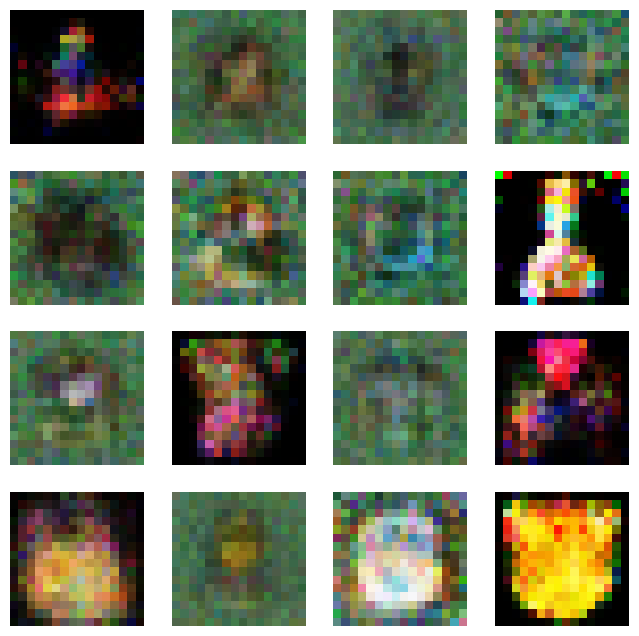

In [423]:
import matplotlib.pyplot as plt

# Function to visualize generated emojis
def visualize_emojis(generator, num_images=16, fixed_noise_dim=100):
    generator.eval()  # Set generator to evaluation mode

    # Generate fixed noise
    fixed_noise = torch.randn(num_images, fixed_noise_dim).to(device)
    
    # Randomly select embeddings from the dataset and convert efficiently
    random_embeddings = torch.tensor(np.array(df["combined_embedding"].sample(num_images).to_list())).to(device)

    # Generate images using noise and embeddings separately
    with torch.no_grad():
        generated_images = generator(fixed_noise, random_embeddings).cpu()
    
    # Denormalize the images
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Plot the images
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].permute(1, 2, 0).numpy())
        plt.axis('off')
    
    plt.show()

# Call the function to visualize the emojis
visualize_emojis(generator)

In [424]:
# # Loading the same SBERT model
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# 
# # Sample prompt text
# sample_text = "happy face with heart eyes"
# sample_embedding = sbert_model.encode([sample_text], convert_to_tensor=True)
# sample_embedding = sample_embedding.float().to(device)
# 
# def generate_emoji(generator, embedding, num_samples=1):
#     generator.eval()  # Set to evaluation mode
#     noise = torch.randn(num_samples, latent_dim).to(device)  # Random noise for generation
# 
#     with torch.no_grad():
#         generated_images = generator(noise, embedding)
#     generated_images = generated_images.cpu() * 0.5 + 0.5  # Denormalize
# 
#     return generated_images
# 
# import matplotlib.pyplot as plt
# 
# def visualize_generated_emoji(generated_images):
#     num_samples = generated_images.size(0)
#     fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
#     if num_samples == 1:
#         axes = [axes]  # Ensure axes is always iterable
# 
#     for i, img in enumerate(generated_images):
#         axes[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from Tensor format
#         axes[i].axis('off')
#     plt.show()
# 
# # Generate and visualize the emoji
# generated_emoji = generate_emoji(generator, sample_embedding)
# visualize_generated_emoji(generated_emoji)